Статья, из которой заимствован метод оптимизации нейросети:
https://arxiv.org/pdf/1704.04289.pdf

In [1]:
import tensorflow as tf
import numpy as np
from ipywidgets import IntProgress
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

Класс SimpleTwoLayerNN задает архитектуру полносвязной нейросети с одним скрытым слоем. Принимает на вход размерности входа, скрытого слоя и выхода. Поддерживает задачи классификации и регрессии.

Весь функционал модели реализован в классе NNFunctional

In [2]:
class SimpleTwoLayerNN():
    def __init__(self, input_dim, hidden_size, output_dim, mode='regression'):
        xavier = np.sqrt(6.0/(input_dim+hidden_size))
        xavier2 = np.sqrt(6.0/(output_dim+hidden_size))
        #weights matrices and vectors of the nn
        self.hidden_weights = tf.Variable(tf.random_uniform((input_dim, hidden_size),
                                                    minval=-xavier, maxval=xavier, dtype=tf.float64),
                                  name='hidden_weights')
        self.hidden_bias = tf.Variable(tf.random_uniform((hidden_size,),
                                                         minval=-xavier, maxval=xavier, dtype=tf.float64), 
                                       name='hidden_bias')
        self.output_weights = tf.Variable(tf.random_uniform((hidden_size, output_dim),
                                                            minval=-xavier2, maxval=xavier2, dtype=tf.float64), 
                                          name='output_weights')
        self.output_bias = tf.Variable(tf.random_uniform((output_dim,), minval=-xavier2, maxval=xavier2, dtype=tf.float64), 
                                       name='output_bias')

        #0-1 matrices to disable/enable optimization to parameters
        self.hidden_opt_matrix = tf.ones(self.hidden_weights.shape, dtype=tf.float64)
        self.output_opt_matrix = tf.ones(self.output_weights.shape, dtype=tf.float64)

        #creating tensors for input, target and output
        self.X = tf.placeholder(tf.float64, [None, input_dim])
        self.Y = tf.placeholder(tf.int32, [None, 1])
        self.hidden_layer = tf.nn.tanh(tf.add(self.hidden_bias, tf.matmul(self.X, self.hidden_weights)))
        if mode == 'regression':
            self.output = tf.nn.relu(tf.add(self.output_bias, tf.matmul(self.hidden_layer, self.output_weights)))
        if mode == 'classification':
            self.output = tf.nn.softmax(tf.add(self.output_bias, tf.matmul(self.hidden_layer, self.output_weights)))
        if mode == 'regression':
            self.prediction = self.output
        if mode == 'classification':
            self.prediction = tf.argmax(self.output, axis=1)

        #creating input, target and output of size of one to compute C
        self.X_one = tf.placeholder(tf.float64, [1, input_dim])
        self.Y_one = tf.placeholder(tf.int32, [1, 1])
        self.hidden_for_one = tf.nn.tanh(tf.add(self.hidden_bias, tf.matmul(self.X_one, self.hidden_weights)))
        if mode == 'regression':
            self.output_for_one = tf.nn.relu(tf.add(self.output_bias, tf.matmul(self.hidden_for_one, self.output_weights)))
        if mode == 'classification':
            self.output_for_one = tf.nn.softmax(tf.add(self.output_bias, tf.matmul(self.hidden_for_one, self.output_weights)))

        
    def get_all_weights(self):
        return [self.hidden_weights, self.hidden_bias, self.output_weights, self.output_bias]
    
    def get_opt_matrices(self):
        return [self.hidden_opt_matrix,
                tf.ones(self.hidden_bias.shape, dtype=tf.float64),
                self.output_opt_matrix,
                tf.ones(self.output_bias.shape, dtype=tf.float64)]
    
    def get_outputs(self):
        return self.output, self.output_for_one
    
    def get_prediction(self):
        return self.prediction
    
    def get_n_params(self): #returns the whole number of nn's params
        hidden_weights_size = int(np.product(self.hidden_weights.shape))
        hidden_bias_size = int(np.product(self.hidden_bias.shape))
        output_weights_size = int(np.product(self.output_weights.shape))
        output_bias_size = int(np.product(self.output_bias.shape))
        N = hidden_weights_size + hidden_bias_size + output_weights_size + output_bias_size
        return N
    
    def get_xy(self):
        return self.X, self.X_one, self.Y, self.Y_one
    
    def predict(self, X, session):
        return session.run(self.prediction, feed_dict={self.X:X})

In [3]:
from sklearn.metrics import accuracy_score

Класс NNFunctional принимает в качестве парамтеров инициализации нейросеть и параметры для ее обучения и оценки качества. В нем реализованы следующие методы:

* fit - оптимизация параметров нейросети с данными ограничениями
* prune(p) - зануление p*n_params весов с наименьшим абсолютным значением
* disable_optimization(p) - отключение оптимизации для p*n_params весов с наименьшим абсолютным значением в precondition-матрице
* reset_all_params - возврат нейросети в исходное состояние для последующего обучения "с нуля"

In [4]:
class NNFunctional():
    def __init__(self, model,
                 loss,
                 metric, 
                 learning_rate=1e-3, 
                 batch_size=32):
        
        #initializing train and evaluation parameters
        self.model = model
        self.loss = loss
        self.metric = metric
        self.session = tf.Session()
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        #-------------------------------------------------------------------------------------------------------------
        #creating computation graph
        #-------------------------------------------------------------------------------------------------------------
        
        #inputs, targets and outputs of the model, for batch and for single element
        self.output, self.output_for_one = self.model.get_outputs()
        self.X, self.X_one, self.Y, self.Y_one = self.model.get_xy()
        self.model_weights = self.model.get_all_weights()
        self.n_weights = len(self.model_weights)
        
        #0-1 matrices that disable/enable optimization of a parameter, and their update operations
        self.opt_matrices = [tf.Variable(matrix, dtype=tf.float64, trainable=False) \
                             for matrix in self.model.get_opt_matrices()]
        self.opt_placeholders = [tf.placeholder(dtype=tf.float64, shape=self.opt_matrices[i].shape) \
                                 for i in range(self.n_weights)]
        self.update_opt_matrices = [self.opt_matrices[i].assign(self.opt_placeholders[i]) \
                                    for i in range(self.n_weights)]
        #whole number of model's parameters
        self.N = self.model.get_n_params()
        
        #tensors of prediction and score of the model
        self.prediction = self.model.get_prediction()
        self.model_score = self.metric(self.prediction, self.Y)
        
        #C is the covariance matrix of gradient noise (see the article)
        self.C = [tf.Variable(tf.ones(matrix.shape, dtype=tf.float64)) for matrix in self.model_weights]
        #H is the preconditioner (the article, corollary 3)
        self.H = [2 * self.batch_size / (self.N * c) for c in self.C]
        
        #creating tensors for losses and gradients
        self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
        self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
        self.loss_function = tf.reduce_mean(self.loss(self.Y, self.output))
        self.loss_function = tf.reduce_mean(self.loss(self.Y, self.output))
        self.loss_for_one = tf.reduce_mean(self.loss(self.Y_one, self.output_for_one))
        self.gradients = [x[0] for x in self.optimizer.compute_gradients(self.loss_function, \
                                                                          var_list=self.model_weights)]
        self.gradients_for_one = [x[0] for x in self.optimizer.compute_gradients(self.loss_for_one, \
                                                                                 var_list=self.model_weights)]
        
        #creating update operations for weights and covariance matrix C
        self.new_model_weights = [self.model_weights[i] - self.opt_matrices[i] * self.gradients[i] * self.H[i] \
                            for i in range(self.n_weights)]
        self.update_weights = [self.model_weights[i].assign(self.new_model_weights[i]) \
                               for i in range(self.n_weights)]
        #online estimating C (see the article, page 12)
        self.new_C = [(1 - self.learning_rate) * self.C[i] + \
                      self.learning_rate * (self.gradients_for_one[i] - self.gradients[i]) ** 2 \
                 for i in range(self.n_weights)]
        self.update_C = [self.C[i].assign(self.new_C[i]) for i in range(self.n_weights)]
        
        #tensors for changing weights in function prune
        self.weight_placeholders = [tf.placeholder(dtype=tf.float64, \
                                                   shape=self.model_weights[i].shape) \
                                    for i in range(self.n_weights)]
        self.change_weights = [self.model_weights[i].assign(self.weight_placeholders[i]) \
                               for i in range(self.n_weights)]
        

    
    def fit(self, 
            X_train,
            y_train,
            steps,
            val_data=None,
            verbose_freq=0,
            warm_start=False,
            print_out=True,
            tqdm=True):        
        
        if val_data is not None:
            X_val, y_val = val_data
        train_history = []
        val_history = []
        
        #intitalizing variables
        init_op = tf.global_variables_initializer()
        local_op = tf.local_variables_initializer()
        if not warm_start:
            self.session.run(init_op)
        self.session.run(local_op)
        
        #--------------------------------------------------------------------------------------------------------------
        #train loop
        #--------------------------------------------------------------------------------------------------------------
        
        if tqdm:
            step_numbers = tqdm_notebook(np.arange(steps))
        else:
            step_numbers = range(steps)
        for i in step_numbers:
            
            #creating batch and single element for the trian step
            ids = np.random.choice(np.arange(len(X_train)), size=self.batch_size)
            batch = X_train[ids]
            labels = y_train[ids]
            one_id = np.random.choice(np.arange(len(X_train)), size=1)
            one_X = X_train[one_id]
            one_y = y_train[one_id]
            
            #train step: updating parameters
            inputs = {self.X:batch, self.Y:labels, self.X_one:one_X, self.Y_one:one_y}
            self.session.run(self.update_weights, feed_dict=inputs)
            self.session.run(self.update_C, feed_dict=inputs)
            
            #showing and saving current model score on train and validation
            if i % verbose_freq == 0 and verbose_freq > 0:
                self.session.run(local_op)
                train_score = self.session.run(self.model_score, feed_dict={self.X:X_train, self.Y:y_train})
                train_history.append(train_score)
                if val_data is not None:
                    val_score = self.session.run(self.model_score, feed_dict={self.X:X_val, self.Y:y_val})
                    val_history.append(val_score)

                if print_out:
                    print('step number', i)
                    print('train score', train_score)
                    print('validation score', val_score)
        return train_history, val_history
        
    def prune(self, p):
        #getting current weights and values of optimization matrices
        weights = self.session.run(self.model_weights)
        opt_matrices = self.session.run(self.opt_matrices)
        new_weights = []
        new_opt = []
        
        #set p*N weights with lowest absolute value to zero, and set their optimization coefs to zero
        for matrix, opt_matrix in zip(weights, opt_matrices):
            weight_vector = matrix.ravel()
            opt_vector = opt_matrix.ravel()
            n_params_to_cut = int(weight_vector.shape[0] * p)
            argsort = np.argsort(np.abs(weight_vector))
            params_to_cut = argsort[:n_params_to_cut]
            weight_vector[params_to_cut] = 0
            opt_vector[params_to_cut] = 0
            new_weights.append(weight_vector.reshape(matrix.shape))
            new_opt.append(opt_vector.reshape(opt_matrix.shape))
            
        #updating tensors of weights and optimization matrices
        self.session.run(tf.local_variables_initializer())
        for i in range(self.n_weights):
            self.session.run(self.change_weights[i], feed_dict={self.weight_placeholders[i]:new_weights[i]})
            self.session.run(self.update_opt_matrices[i], feed_dict={self.opt_placeholders[i]:new_opt[i]})
        self.session.run(tf.local_variables_initializer())
    
    def disable_optimization(self, p):
        opt_matrices = self.session.run(self.opt_matrices)
        C = self.session.run(self.C)
        H = [1 / c for c in C] #really, H is proportional to 1/C
        new_opt = []
        
        #setting optimization coefs of p*N params with fewest absolute H values to zero
        for matrix, opt_matrix in zip(H, opt_matrices):
            H_vector = matrix.ravel()
            opt_vector = opt_matrix.ravel()
            n_params_to_disable = int(H_vector.shape[0] * p)
            argsort = np.argsort(np.abs(H_vector))
            params_to_disable = argsort[:n_params_to_disable]
            opt_vector[params_to_disable] = 0
            new_opt.append(opt_vector.reshape(opt_matrix.shape))
            
        #running the changes
        for i in range(self.n_weights):
            self.session.run(self.update_opt_matrices[i], feed_dict={self.opt_placeholders[i]:new_opt[i]})
            
    def reset_all_params(self):
        #setting all the parameters of the model to the initial state
        init_op = tf.global_variables_initializer()
        local_op = tf.local_variables_initializer()
        self.session.run(init_op)
        self.session.run(local_op)
        self.session.run(self.model_weights)
        for i in range(self.n_weights):
            self.opt_matrices[i] = tf.ones(self.opt_matrices[i].shape, dtype=tf.float64)

## Digits

Проведем вычислительный эксперимент на датасете digits (классификация рукописных цифр, 64 признака, 10 классов).

В качестве функции потерь возьмем кроссэнтропию, метрику качества - accuracy.

In [5]:
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=42, test_size=0.3)
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
eps = 1e-8
X_train = (X_train - X_mean) / (X_std + eps)
X_test = (X_test - X_mean) / (X_std + eps)

/home/kirill/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
nn = SimpleTwoLayerNN(X_train.shape[1], 32, 10, mode='classification')
func = NNFunctional(model=nn, 
                    loss=tf.losses.sparse_softmax_cross_entropy, 
                    metric=lambda x, y:tf.metrics.accuracy(x, y)[1],
                    learning_rate=1e-3,
                    batch_size=32)

### Prune

Для разных значений р проведем 1000 шагов полной оптимизации, затем занулим p*N весов и проведем еще 4000 шагов оптимизации остальных весов. Построим график качества модели в зависимости от р

In [7]:
prune_params = np.linspace(0, 1, 51)[:-1]
train_accs = []
val_accs = []
for p in tqdm_notebook(prune_params):
    train_acc = []
    val_acc = []
    for _ in range(5):
        train_history, val_history = func.fit(X_train,
                                             y_train,
                                             steps=1000,
                                             val_data=(X_test, y_test),
                                             verbose_freq=999,
                                             warm_start=False,
                                             print_out=False,
                                             tqdm=False
                                            )
        func.prune(p)
        train_history, val_history = func.fit(X_train,
                                             y_train,
                                             steps=4000,
                                             val_data=(X_test, y_test),
                                             verbose_freq=3999,
                                             warm_start=True,
                                             print_out=False,
                                             tqdm=False
                                            )
        func.reset_all_params()
        train_acc.append(train_history[-1])
        val_acc.append(val_history[-1])
    train_accs.append(train_acc)
    val_accs.append(val_acc)

In [8]:
train_accs = np.array(train_accs)
val_accs = np.array(val_accs)

In [9]:
np.savetxt('./prune_train_acc.txt', train_accs)
np.savetxt('./prune_val_acc.txt', val_accs)

In [10]:
train_accs.shape

(50, 5)

Text(0,0.5,'Accuracy')

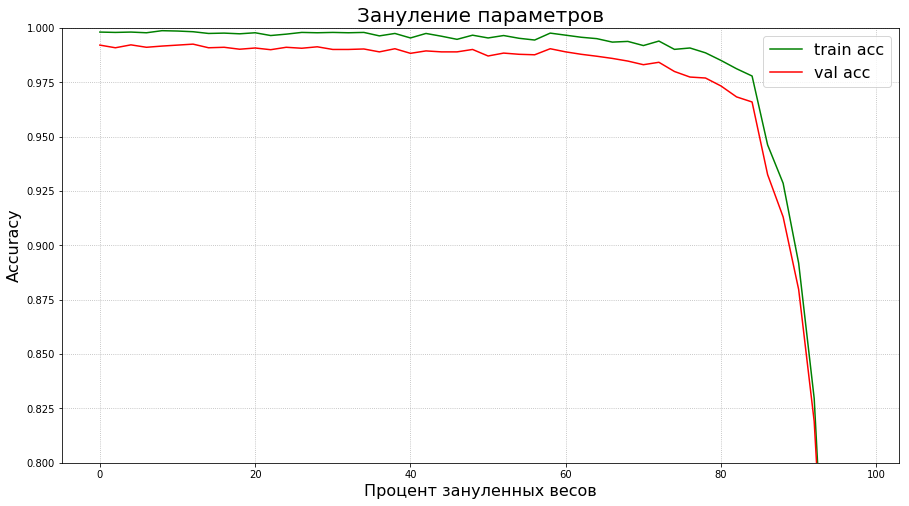

In [25]:
plt.figure(figsize=(15, 8))
plt.title('Зануление параметров', fontsize=20)
plt.grid(ls=':')
plt.plot(prune_params * 100, train_accs.mean(axis=1), color='g', label='train acc')
plt.plot(prune_params * 100, val_accs.mean(axis=1), color='r', label='val acc')
plt.legend(fontsize=16)
plt.ylim((0.8, 1))
plt.xlabel('Процент зануленных весов', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

### Disable optimization

Для разных значений р проведем 1000 шагов полной оптимизации, затем отключим оптимизацию для p*N параметров и проведем еще 4000 шагов оптимизации остальных весов. Построим график качества модели в зависимости от р

In [21]:
disable_params = np.linspace(0, 1, 51)
train_accs_disable = []
val_accs_disable = []
for p in tqdm_notebook(disable_params):
    train_acc = []
    val_acc = []
    for _ in range(5):
        train_history, val_history = func.fit(X_train,
                                             y_train,
                                             steps=1000,
                                             val_data=(X_test, y_test),
                                             verbose_freq=999,
                                             warm_start=False,
                                             print_out=False,
                                             tqdm=False
                                            )
        func.disable_optimization(p)
        train_history, val_history = func.fit(X_train,
                                             y_train,
                                             steps=4000,
                                             val_data=(X_test, y_test),
                                             verbose_freq=3999,
                                             warm_start=True,
                                             print_out=False,
                                             tqdm=False
                                            )
        func.reset_all_params()
        train_acc.append(train_history[-1])
        val_acc.append(val_history[-1])
    train_accs_disable.append(train_acc)
    val_accs_disable.append(val_acc)

In [22]:
train_accs_disable = np.array(train_accs_disable)
val_accs_disable = np.array(val_accs_disable)
print(train_accs_disable.shape, val_accs_disable.shape)

(51, 5) (51, 5)


In [23]:
np.savetxt('./disable_train_acc.txt', train_accs_disable)
np.savetxt('./disable_val_acc.txt', val_accs_disable)

Text(0,0.5,'Accuracy')

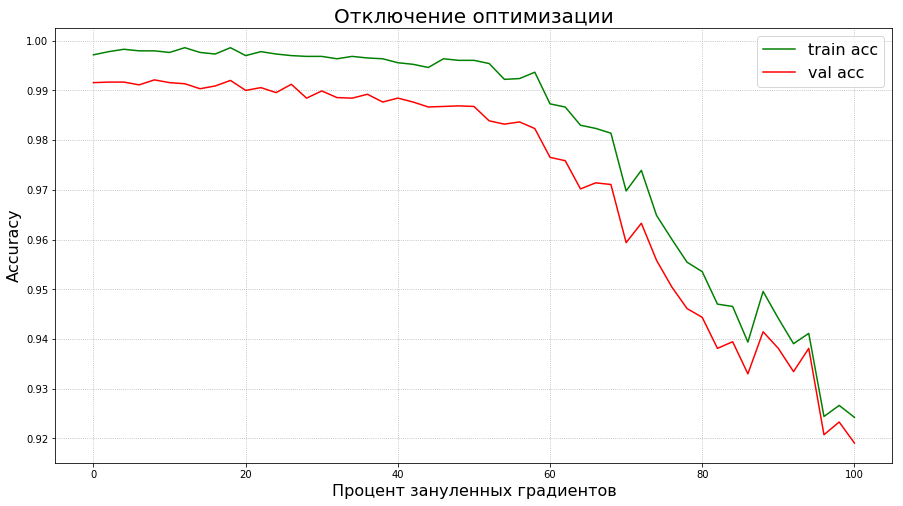

In [24]:
plt.figure(figsize=(15, 8))
plt.title('Отключение оптимизации', fontsize=20)
plt.grid(ls=':')
plt.plot(disable_params * 100, train_accs_disable.mean(axis=1), color='g', label='train acc')
plt.plot(disable_params * 100, val_accs_disable.mean(axis=1), color='r', label='val acc')
plt.legend(fontsize=16)
plt.xlabel('Процент зануленных градиентов', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)